Số hàng: 921
Số lượng điểm dữ liệu:  921
Số lượng đặc trưng: 42
Số lượng nhãn khác nhau: 23
Các nhãn khác nhau: {'satan', 'teardrop', 'portsweep', 'pod', 'normal', 'rootkit', 'spy', 'land', 'guess_passwd', 'back', 'ftp_write', 'imap', 'warezclient', 'perl', 'phf', 'loadmodule', 'warezmaster', 'buffer_overflow', 'ipsweep', 'neptune', 'nmap', 'smurf', 'multihop'}
Số hàng có chứa giá trị NULL:  0


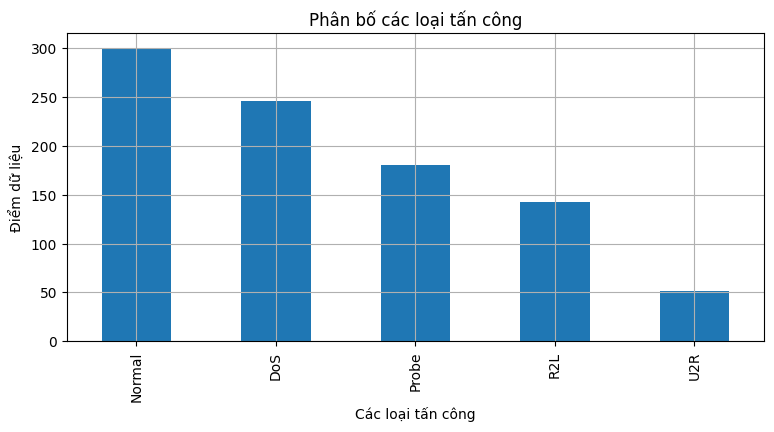

Số lượng điểm dữ liệu sau tiền xử lý:  921
Số điểm dữ liệu trong loại "Normal" : 300 ( 32.573 %)
Số điểm dữ liệu trong loại "DoS" : 246 ( 26.71 %)
Số điểm dữ liệu trong loại "Probe" : 180 ( 19.544 %)
Số điểm dữ liệu trong loại "R2L" : 143 ( 15.527 %)
Số điểm dữ liệu trong loại "U2R" : 52 ( 5.646 %)


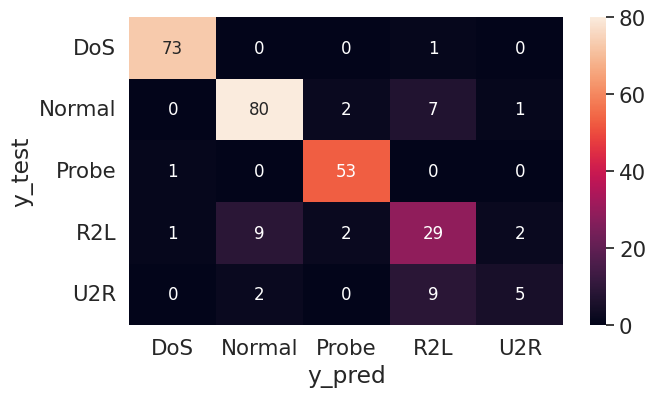

Độ chính xác của mô hình SVM: 0.8664259927797834
Báo cáo đánh giá mô hình SVM:
              precision    recall  f1-score   support

         DoS       0.97      0.99      0.98        74
      Normal       0.88      0.89      0.88        90
       Probe       0.93      0.98      0.95        54
         R2L       0.63      0.67      0.65        43
         U2R       0.62      0.31      0.42        16

    accuracy                           0.87       277
   macro avg       0.81      0.77      0.78       277
weighted avg       0.86      0.87      0.86       277



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu từ KDD-99
df = pd.read_csv("my_kddcup99.csv")


# Phân tích cơ bản KDD-99
print('Số hàng: {}'.format(len(df)))
print('Số lượng điểm dữ liệu: ', df.shape[0])
print('Số lượng đặc trưng:', df.shape[1])
output = df['label'].values
labels = set(output)
print('Số lượng nhãn khác nhau:', len(labels))
print('Các nhãn khác nhau:', labels)


# Tiền xử lý dữ liệu

# Xử lý giá trị NULL
print('Số hàng có chứa giá trị NULL: ',len(df[df.isnull().any(axis=1)]))
# Xác định kiểu dữ liệu
data_types = df.dtypes
# Xử lý giá trị NULL với kiểu dữ liệu tương ứng
for column in df.columns:
    if data_types[column] == 'object':
        # Kiểu dữ liệu phân loại (categorical)
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
    elif data_types[column] == 'float':
        # Kiểu dữ liệu liên tục (continuous)
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

# Mã hóa one-hot dữ liệu string
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

# Phân loại tấn công
def categorize_attack(attack):
    if attack in ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']:
        return 'DoS'
    elif attack in ['ipsweep', 'nmap', 'portsweep', 'satan']:
        return 'Probe'
    elif attack in ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']:
        return 'U2R'
    elif attack in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']:
        return 'R2L'
    else:
        return 'Normal'
df['attack_category'] = df['label'].apply(categorize_attack)

# Phân bố dữ liệu sau tiền xử lý
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
class_distribution = df['attack_category'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Các loại tấn công')
plt.ylabel('Điểm dữ liệu')
plt.title('Phân bố các loại tấn công')
plt.grid()
plt.show()
print('Số lượng điểm dữ liệu sau tiền xử lý: ', df.shape[0])
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Số điểm dữ liệu trong loại "{}"'.format(class_distribution.index[i]),':', class_distribution.values[i],
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

# Xây dựng mô hình SVM
x = df.drop(columns=['label', 'attack_category'])
y = df['attack_category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
svm_model = SVC(kernel='linear', C=1.0)  # Chọn kernel và các siêu tham số tương ứng
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

# Tính ma trận nhầm lẫn
confusion = confusion_matrix(y_test, y_pred)
# Định nghĩa danh sách nhãn lớp
labels = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

# Tạo DataFrame từ ma trận nhầm lẫn
cm_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Tạo biểu đồ heatmap
plt.figure(figsize=(7, 4))
sns.set(font_scale=1.4)
sns.heatmap(cm_df, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('y_test')
plt.xlabel('y_pred')
plt.show()

# Đánh giá mô hình SVM
accuracy_svm = accuracy_score(y_test, y_pred)
print("Độ chính xác của mô hình SVM:", accuracy_svm)

# Báo cáo đánh giá chi tiết
print("Báo cáo đánh giá mô hình SVM:")
print(classification_report(y_test, y_pred))

